# Colab setting

Mount google drive

In [49]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/drive')


!unzip '/content/drive/MyDrive/drive/CMRI/Lab9/Data/data.zip' -d '/content/drive/MyDrive/drive/CMRI/Lab9/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/drive/CMRI/Lab9/Data/data.zip, /content/drive/MyDrive/drive/CMRI/Lab9/Data/data.zip.zip or /content/drive/MyDrive/drive/CMRI/Lab9/Data/data.zip.ZIP.


Add CMRI path to the Colab environment


In [2]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/CMRI/Lab9")

# Import modules

In [50]:
import numpy as np
np.random.seed(123)  # for reproducibility

import pandas
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.utils.data as data_utils
from torchsummary import summary
from time import time
torch.manual_seed(123)  # for reproducibility


## Entries in the CVS file 


1. sample
2. row
3. column
4. slice
5. T1 weighted anatomical Image
6. FA (Fractional Anisotropy)
7. MD (Mean Diffusivity)
8. AD (Azial Diffusivity)
9. RD (Radial Diffusivity)
10. Label (class)
>- Thalamus
>-Corpus callosum (CC)
>-Cortical white matter (Cortical WM)

# data
## Load data
- data1: test data
- data2~4: training and validation 

In [51]:
data1 = pandas.read_csv("/content/drive/MyDrive/drive/CMRI/Lab9/Data/dti/sampledata100206.csv", header=None).values 
data2 = pandas.read_csv("/content/drive/MyDrive/drive/CMRI/Lab9/Data/dti/sampledata105620.csv", header=None).values 
data3 = pandas.read_csv("/content/drive/MyDrive/drive/CMRI/Lab9/Data/dti/sampledata107725.csv", header=None).values 
data4 = pandas.read_csv("/content/drive/MyDrive/drive/CMRI/Lab9/Data/dti/sampledata112314.csv", header=None).values 

data_cat = np.concatenate((data2,data3,data4),axis=0)

Remove classes and slice position features

In [69]:
x_test = data1[:,4:9].astype(float)
y_test = data1[:,9]-1 # class labels are expected to start at 0
X = data_cat[:,4:9].astype(float)
Y = data_cat[:,9]-1 # class labels are expected to start at 0

## Normalize data

In [102]:
nSamples = np.size(Y)
nSamples_test = np.size(y_test)
nClasses = int(np.max(Y))+1
nFeatures = np.size(X,1)

for ii in range(0,nFeatures):
    feature_normalization = max(X[:,ii])
    X[:,ii] = X[:,ii]/feature_normalization
    x_test[:,ii] = x_test[:,ii]/feature_normalization

print(nClasses, nFeatures)

3 5


## Separate training and validation


In [71]:
trainSet_ratio = 0.8
setsize_train = np.ceil(nSamples * trainSet_ratio).astype(int)

x_train = X[:setsize_train, :]
y_train = Y[:setsize_train]

x_val = X[setsize_train:, :]
y_val = Y[setsize_train:]

## Generate torch variables

In [72]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = torch.Tensor(x_train).float().to(DEVICE)
y_train = torch.Tensor(y_train).long().to(DEVICE)

x_val = torch.Tensor(x_val).float().to(DEVICE)
y_val = torch.Tensor(y_val).long().to(DEVICE)

x_test = torch.Tensor(x_test).float().to(DEVICE)
y_test = torch.Tensor(y_test).long().to(DEVICE)

print(DEVICE, x_train.shape)

cuda torch.Size([14044, 5])


# Model


Define model


In [97]:
class dti_FC(nn.Module):
  def __init__(self):
      super(dti_FC, self).__init__()
        
      # define the layers
      self.layers = model = torch.nn.Sequential(
                              torch.nn.Linear(nFeatures, elements, bias=True),
                              torch.nn.ReLU(),
                              torch.nn.Linear(elements, elements, bias=True),
                              torch.nn.ReLU(),
                              torch.nn.Linear(elements, elements, bias=True),
                              torch.nn.ReLU(),  
                              torch.nn.Linear(elements, elements, bias=True),
                              torch.nn.ReLU(),
                              torch.nn.Dropout1d(0.25),
                              torch.nn.Linear(elements, nClasses, bias=True))

  def forward(self, x):
      # forward pass
      x = torch.sigmoid(self.layers(x))
      return x


In [98]:
elements = 100
model_name = "dti_FC_dropout"
model = dti_FC()

model = model.to(DEVICE)
summary(model, input_size=(14044, 5), batch_size=1024)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1         [1024, 14044, 100]             600
              ReLU-2         [1024, 14044, 100]               0
            Linear-3         [1024, 14044, 100]          10,100
              ReLU-4         [1024, 14044, 100]               0
            Linear-5         [1024, 14044, 100]          10,100
              ReLU-6         [1024, 14044, 100]               0
            Linear-7         [1024, 14044, 100]          10,100
              ReLU-8         [1024, 14044, 100]               0
         Dropout1d-9         [1024, 14044, 100]               0
           Linear-10           [1024, 14044, 3]             303
Total params: 31,203
Trainable params: 31,203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 274.30
Forward/backward pass size (MB): 99076.03
Params size (MB): 0.12
Estimat

# Optimizer & Loss

In [99]:
lr = 1E-2
batch_size = 1024
training_epochs = 250
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

## Dataloader

In [100]:
dataloader_train = data_utils.TensorDataset(x_train, y_train)
dataloader_train = data_utils.DataLoader(dataloader_train, batch_size=batch_size, shuffle=True, num_workers=0)

# Train Model

In [101]:
loss_train = np.zeros(training_epochs)
acc_train = np.zeros(training_epochs)
loss_val = np.zeros(training_epochs)
acc_val = np.zeros(training_epochs)

time0 = time()
with tqdm(total=training_epochs, unit='Epoch', leave=True) as pbar:
  for epoch in range(training_epochs):
      torch.cuda.empty_cache()   
      for local_batch, local_labels in dataloader_train:
          # training step
          out = model(local_batch)
          optimizer.zero_grad()
          loss = criterion(out, local_labels)
          loss.backward()
          optimizer.step()

          loss_train[epoch] = loss.item()
          [dummy, predicted] = torch.max(out.data, 1)
          acc_train[epoch] = (torch.sum(local_labels == predicted) / local_labels.size()[0]).item()

          # validation
      out_val = model(x_val)
      loss = criterion(out_val, y_val)
      loss_val[epoch] = loss.item()
      [dummy, predicted_val] = torch.max(out_val.data, 1)
      acc_val[epoch] = (torch.sum(y_val == predicted_val) / y_val.size()[0]).item()


      pbar.set_description(desc=f"Epoch {epoch: 3d}")
      pbar.set_postfix({"train loss": f"{loss_train[epoch]: .3f}",
                        "train acc": f"{acc_train[epoch]: .3f}",
                        "val loss": f"{loss_val[epoch]: .3f}",
                        "val acc": f"{acc_val[epoch]: .3f}"})
      pbar.update()

print(f"\nTraining Time (in minutes) = {(time() - time0) / 60}\n")

  0%|          | 0/250 [00:00<?, ?Epoch/s]


Training Time (in minutes) = 0.5625946084658305



# Evaluation
## Double check model on train data

In [103]:
out_train = model(x_train.to(DEVICE))
[dummy, predicted] = torch.max(out_train.data, 1)
acc_train_final = (torch.sum(y_train.to(DEVICE) == predicted) / y_train.size()[0]).item()
print(f"Evaluation results of train data :{acc_train_final}")

Evaluation results of train data :0.7556963562965393


## Double check model on validation data

In [104]:
out_val = model(x_val.to(DEVICE))
[dummy, predicted_val] = torch.max(out_val.data, 1)
acc_val_final = (torch.sum(y_val.to(DEVICE) == predicted_val) / y_val.size()[0]).item()
print(f"Evaluation results of validation data :{acc_val_final:.2}")

Evaluation results of validation data :0.65


## Evaluate model on test data

In [105]:
out_test = model(x_test.to(DEVICE))
[dummy, predicted] = torch.max(out_test.data, 1)
acc_test_final = (torch.sum(y_test.to(DEVICE) == predicted) / y_test.size()[0]).item()
print(f"Evaluation results of train data :{acc_test_final}")

Evaluation results of train data :0.7116355299949646


## Plot training overview

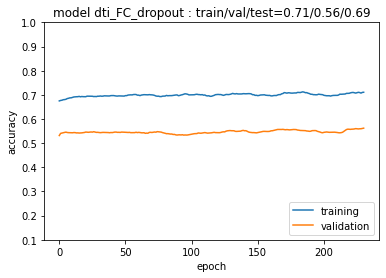

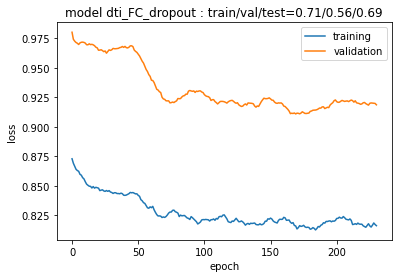

In [95]:
plot_train = f"model {model_name} : train/val/test={acc_train_final:.2}/{acc_val_final:.2}/{acc_test_final:.2}"

N1=20
N = 20
plt.figure()
plt.plot(np.convolve(acc_train, np.ones((N1,))/N1, mode='valid'))
plt.plot(np.convolve(acc_val, np.ones((N,))/N, mode='valid'))
plt.title(plot_train)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['training', 'validation'], loc = 'lower right')
plt.ylim(0.1, 1.0)
plt.show()

plot_train = f"model {model_name} : train/val/test={acc_train_final:.2}/{acc_val_final:.2}/{acc_test_final:.2}"

N1=20
N = 20
plt.figure()
plt.plot(np.convolve(loss_train, np.ones((N1,))/N1, mode='valid'))
plt.plot(np.convolve(loss_val, np.ones((N,))/N, mode='valid'))
plt.title(plot_train)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['training', 'validation'], loc = 'upper right')
#plt.ylim(0.1, 1.0)
plt.show()